# Reading in of Packages

In [1]:
# !pip install scikeras[tensorflow]
# !pip install scikeras[tensorflow-cpu]

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras import Sequential, layers
from tensorflow.keras import optimizers
from scikeras.wrappers import KerasClassifier

random.seed(42)

# Reading in of data

In [3]:
df = pd.read_csv("noshow.csv")

# Data Exploration

In [4]:
print(df.head())
print(df.dtypes)

   booking_id  no_show   branch booking_month arrival_month  arrival_day  \
0       94113      0.0   Changi      November          June         25.0   
1       86543      0.0  Orchard        August      November         28.0   
2       75928      0.0   Changi         March      February          7.0   
3       66947      1.0  Orchard     September       October          1.0   
4      106390      0.0  Orchard         March          June         20.0   

  checkout_month  checkout_day    country first_time    room         price  \
0           June          27.0  Singapore        Yes  Single   SGD$ 492.98   
1       November          29.0  Indonesia        Yes    King  SGD$ 1351.22   
2       February          11.0      India        Yes  Single           NaN   
3        October           3.0      China        Yes  Single   SGD$ 666.04   
4           June          24.0  Australia        Yes   Queen   USD$ 665.37   

  platform num_adults  num_children  
0  Website          1           0.0 

In [5]:
print(df.isna().sum())
df.dropna(subset = ['no_show'], inplace = True)
print(df.isna().sum())

booking_id            0
no_show               1
branch                1
booking_month         1
arrival_month         1
arrival_day           1
checkout_month        1
checkout_day          1
country               1
first_time            1
room              21613
price             24882
platform              1
num_adults            1
num_children          1
dtype: int64
booking_id            0
no_show               0
branch                0
booking_month         0
arrival_month         0
arrival_day           0
checkout_month        0
checkout_day          0
country               0
first_time            0
room              21612
price             24881
platform              0
num_adults            0
num_children          0
dtype: int64


We take note of the number of NA values. We will drop the 1 NA entry in the table. We will look to impute the NA values for `room` and `price` later on. For now, we will do further data exploration.

In [6]:
print(df.describe())
print(df['country'].unique())
print(df['branch'].unique())
print(df['platform'].unique())
print(df['room'].unique())
print(df['no_show'].sum())
uniq_price = np.array([price for price in df['price']])
print(pd.Series([price[:4] for price in uniq_price]).unique())

          booking_id        no_show    arrival_day   checkout_day  \
count  119390.000000  119390.000000  119390.000000  119390.000000   
mean    59694.532281       0.370416      15.798241      14.250507   
std     34465.122764       0.482918       8.780829      11.063697   
min         0.000000       0.000000       1.000000     -31.000000   
25%     29847.250000       0.000000       8.000000       7.000000   
50%     59694.500000       0.000000      16.000000      15.000000   
75%     89541.750000       1.000000      23.000000      23.000000   
max    119390.000000       1.000000      31.000000      31.000000   

        num_children  
count  119390.000000  
mean        0.871229  
std         0.779796  
min         0.000000  
25%         0.000000  
50%         1.000000  
75%         1.000000  
max         3.000000  
['Singapore' 'Indonesia' 'India' 'China' 'Australia' 'Japan' 'Malaysia']
['Changi' 'Orchard']
['Website' 'Agent' 'Email' 'Phone']
['Single' 'King' 'Queen' nan 'President S

We observe the various values for the various categories. One thing to note is that there are 2 different currencies for `price`; USD and SGD. We will convert all the prices to SGD by doing currency exchange.

In [7]:
exchange_rates = {
    'SGD': 1,
    'USD': 1.35,
}

def convert_price(row):
    price = row['price']
    if pd.notna(price) and isinstance(price, str):
        currency = price[:3]
        if currency in exchange_rates:
            # Extract the numeric part of the price, convert to float, and apply the exchange rate
            amount = float(price[5:])
            converted_price = exchange_rates[currency] * amount
            return converted_price
    return price

df['price'] = df.apply(convert_price, axis=1).astype(float)
print(df['price'].describe())

count    94509.000000
mean       942.242501
std        264.061122
min        394.213500
25%        818.120000
50%        905.809500
75%        998.620000
max       2099.960000
Name: price, dtype: float64


In [8]:
print(df.head())

   booking_id  no_show   branch booking_month arrival_month  arrival_day  \
0       94113      0.0   Changi      November          June         25.0   
1       86543      0.0  Orchard        August      November         28.0   
2       75928      0.0   Changi         March      February          7.0   
3       66947      1.0  Orchard     September       October          1.0   
4      106390      0.0  Orchard         March          June         20.0   

  checkout_month  checkout_day    country first_time    room      price  \
0           June          27.0  Singapore        Yes  Single   492.9800   
1       November          29.0  Indonesia        Yes    King  1351.2200   
2       February          11.0      India        Yes  Single        NaN   
3        October           3.0      China        Yes  Single   666.0400   
4           June          24.0  Australia        Yes   Queen   898.2495   

  platform num_adults  num_children  
0  Website          1           0.0  
1  Website      

Now that the price column is fixed, we will take a look at another factor that could affect the `no_show` of the customer, the length of stay. The relevant features for this are the `arrival_month`, `arrival_day`, `checkout_month` and `checkout_day` variables.

In [9]:
print(df['checkout_day'].describe())
print(df['arrival_day'].describe())
print(df[df['checkout_day'] < 0].head())

count    119390.000000
mean         14.250507
std          11.063697
min         -31.000000
25%           7.000000
50%          15.000000
75%          23.000000
max          31.000000
Name: checkout_day, dtype: float64
count    119390.000000
mean         15.798241
std           8.780829
min           1.000000
25%           8.000000
50%          16.000000
75%          23.000000
max          31.000000
Name: arrival_day, dtype: float64
     booking_id  no_show   branch booking_month arrival_month  arrival_day  \
43        76711      1.0  Orchard          July       October          3.0   
69        59927      1.0  Orchard        August     September          7.0   
99        53781      0.0   Changi          July       January          1.0   
117      104943      1.0   Changi     September       October          5.0   
160       11871      1.0   Changi       January          June          3.0   

    checkout_month  checkout_day    country first_time  room      price  \
43         October 

We note that there are negative `checkout_day` values in the dataset. We will take a further look at these rows.

In [10]:
print(df[df['checkout_day'] < 0].head())

# We note that it seems to be a mis-input, and they should be positive instead.
df['checkout_day'] = abs(df['checkout_day'])
print(df[df['checkout_day'] < 0].count())

     booking_id  no_show   branch booking_month arrival_month  arrival_day  \
43        76711      1.0  Orchard          July       October          3.0   
69        59927      1.0  Orchard        August     September          7.0   
99        53781      0.0   Changi          July       January          1.0   
117      104943      1.0   Changi     September       October          5.0   
160       11871      1.0   Changi       January          June          3.0   

    checkout_month  checkout_day    country first_time  room      price  \
43         October          -4.0      China        Yes  King  1417.0200   
69       September         -10.0      India        Yes  King  1302.9795   
99         January          -3.0  Indonesia        Yes   NaN   556.2200   
117        October          -6.0      China        Yes  King   940.9700   
160           June          -5.0      China        Yes  King   796.6215   

    platform num_adults  num_children  
43     Email        two           1.0  


In [11]:
print(df['arrival_month'].unique())
print(df['checkout_month'].unique())

['June' 'November' 'February' 'October' 'September' 'March' 'May' 'August'
 'July' 'January' 'April' 'December' 'ApRiL' 'OcTobeR' 'JuNe' 'JulY'
 'ApriL' 'OctOber' 'DecembEr' 'SeptEmber' 'JanUary' 'JUne' 'FeBruary'
 'JanuarY' 'DEcember' 'SePtember' 'DecembeR' 'MaY' 'NoVember' 'JUly'
 'JunE' 'JuLy' 'FebrUary' 'NOvember' 'SeptemBer' 'OctobeR' 'DecemBer'
 'MarCh' 'AuguSt' 'AugusT' 'APril' 'SepTember' 'NovembEr' 'FEbruary'
 'DeceMber' 'AuGust' 'SepteMber' 'FebruaRy' 'OctoBer' 'JanuaRy' 'MarcH'
 'ApRil' 'AUgust' 'JanuAry' 'NOveMber' 'MaRch' 'AprIl' 'MAy' 'NovemBer'
 'DecEmber' 'MArch' 'JaNuary' 'NovembeR' 'SeptembEr' 'FebruarY'
 'SeptembeR' 'OcTober' 'DeCember' 'FebruAry' 'AugUst' 'NovEmber'
 'NoveMber' 'OctobEr' 'OCtober' 'SEptember' 'JAnuary' 'SeptEMber' 'MAY'
 'FebRuary' 'FeBruarY' 'OCTober' 'JUnE' 'DecEMber' 'FebruaRY' 'NovemBeR'
 'NOvEmber' 'FEbruarY' 'FeBruaRy']
['June' 'November' 'February' 'October' 'September' 'March' 'May' 'August'
 'July' 'January' 'April' 'December']


We also note that for the `arrival_month` column, there are a lot of untidy months. Hence, we will tidy this up in order to calculate the difference in days.

In [12]:
df['arrival_month'] = df['arrival_month'].apply(lambda x: x.title())
print(df['arrival_month'].unique())

['June' 'November' 'February' 'October' 'September' 'March' 'May' 'August'
 'July' 'January' 'April' 'December']


In [13]:
month_day_mapping = {
    'January': 0,
    'February': 31,
    'March': 59,
    'April': 90,
    'May': 120,
    'June': 151,
    'July': 181,
    'August': 212,
    'September': 243,
    'October': 273,
    'November': 304,
    'December': 334
}

df['arrival_day_count'] = df['arrival_month'].map(month_day_mapping) + df['arrival_day']
df['checkout_day_count'] = df['checkout_month'].map(month_day_mapping) + df['checkout_day']

df['length_of_stay'] = df['checkout_day_count'] - df['arrival_day_count']
df.loc[df['length_of_stay'] < 0, 'length_of_stay'] += 365
print(df.head())
print(df['length_of_stay'].value_counts())

   booking_id  no_show   branch booking_month arrival_month  arrival_day  \
0       94113      0.0   Changi      November          June         25.0   
1       86543      0.0  Orchard        August      November         28.0   
2       75928      0.0   Changi         March      February          7.0   
3       66947      1.0  Orchard     September       October          1.0   
4      106390      0.0  Orchard         March          June         20.0   

  checkout_month  checkout_day    country first_time    room      price  \
0           June          27.0  Singapore        Yes  Single   492.9800   
1       November          29.0  Indonesia        Yes    King  1351.2200   
2       February          11.0      India        Yes  Single        NaN   
3        October           3.0      China        Yes  Single   666.0400   
4           June          24.0  Australia        Yes   Queen   898.2495   

  platform num_adults  num_children  arrival_day_count  checkout_day_count  \
0  Website    

We will also take a look at the `num_adults` and `num_children` variables to check if they are ready to be used.

In [14]:
print(df['num_adults'].unique())
print(df['num_children'].unique())

['1' '2' 'one' 'two']
[0. 2. 1. 3.]


In [15]:
number_mapping = {
    'one': '1',
    '1': '1',
    'two': '2',
    '2': '2'
}

df['num_adults'] = df['num_adults'].map(number_mapping).astype(float)
print(df['num_adults'].unique())

[1. 2.]


# Exploratory Data Analysis
Before we decide what should be included as the features for our model, we will perform some exploratory data analysis first.

In [16]:
features = df[['branch', 
               'booking_month', 
               'country', 
               'first_time', 
               'room', 'price', 
               'platform', 
               'num_adults', 
               'num_children', 
               'length_of_stay']]

y = df['no_show']

## `branch` and `no_show`

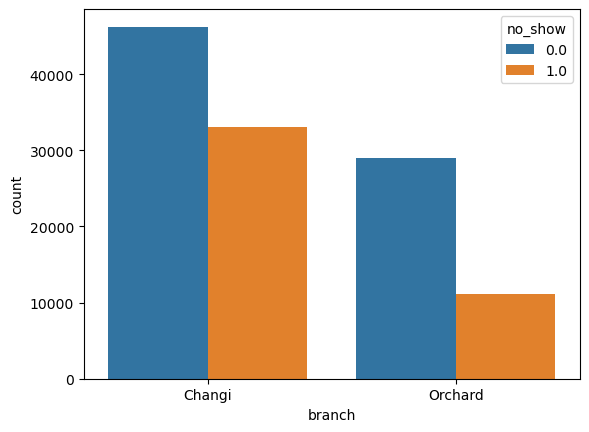

In [17]:
sns.countplot(data = df, x = 'branch', hue = 'no_show')
plt.show()

## `booking_month` and `no_show`

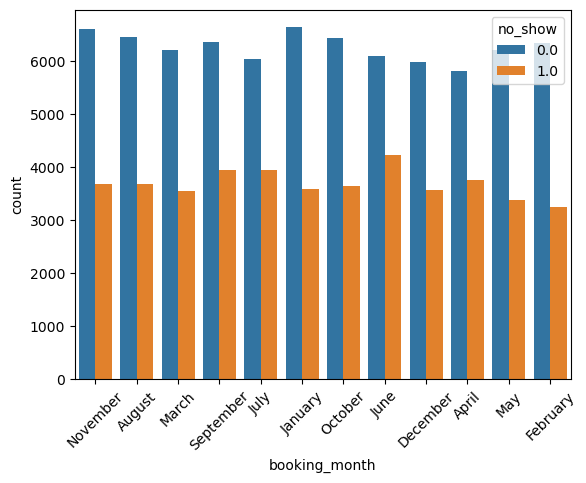

In [18]:
book_plot = sns.countplot(data = df, x = 'booking_month', hue = 'no_show')
book_plot.set_xticklabels(book_plot.get_xticklabels(), rotation=45)
plt.show()

## `country` and `no_show`

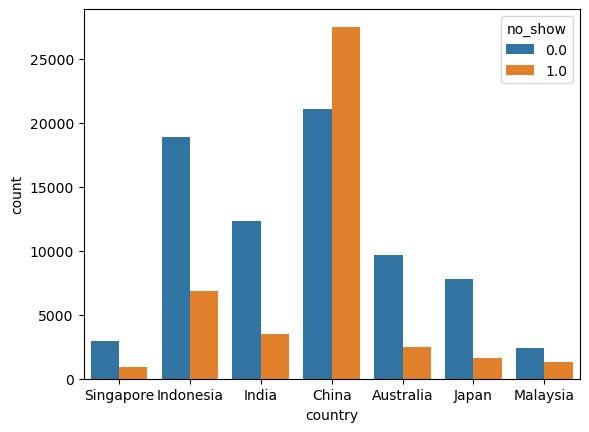

In [19]:
sns.countplot(data = df, x = 'country', hue = 'no_show')
plt.show()

## `first_time` and `no_show`

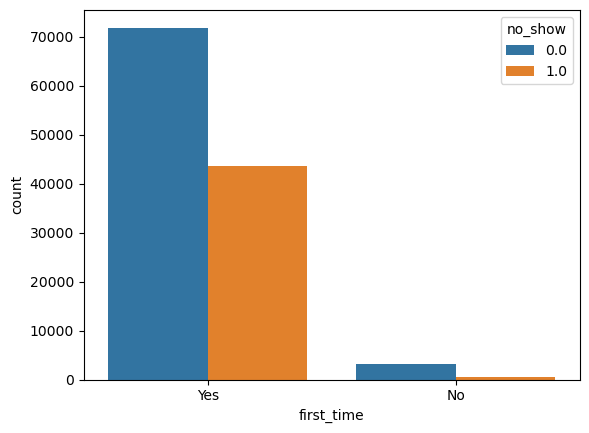

In [20]:
sns.countplot(data = df, x = 'first_time', hue = 'no_show')
plt.show()

## `room` and `no_show`

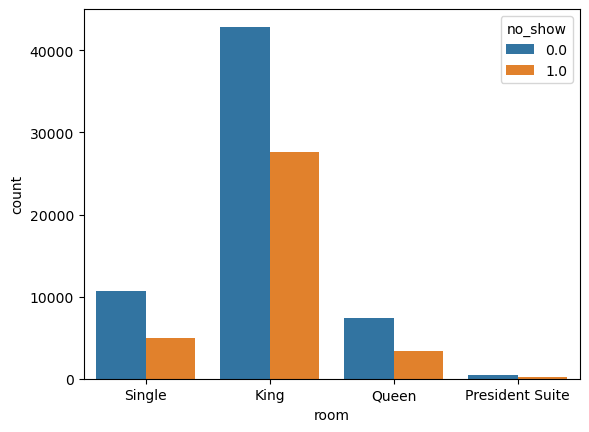

In [21]:
sns.countplot(data = df, x = 'room', hue = 'no_show')
plt.show()

## `price` and `no_show`

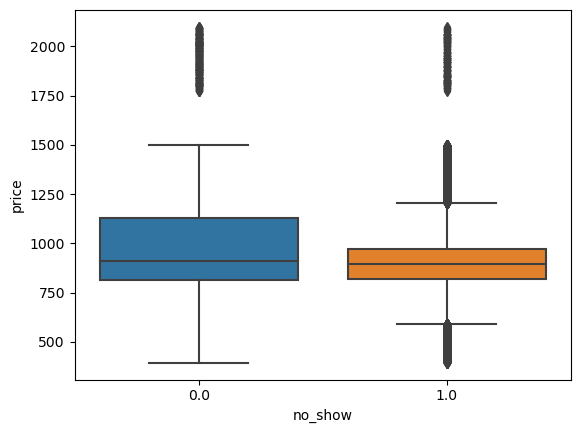

In [22]:
sns.boxplot(data = df, x = 'no_show', y = 'price')
#sns.scatterplot(data = df, x = 'price', y = 'no_show')
plt.show()

## `platform` and `no_show`

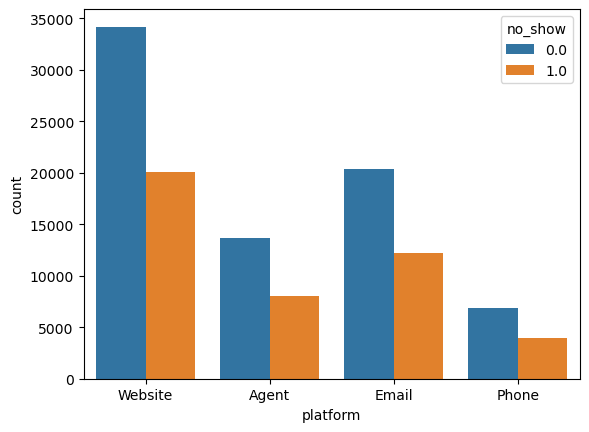

In [23]:
sns.countplot(data = df, x = 'platform', hue = 'no_show')
plt.show()

## `num_adults` and `no_show`

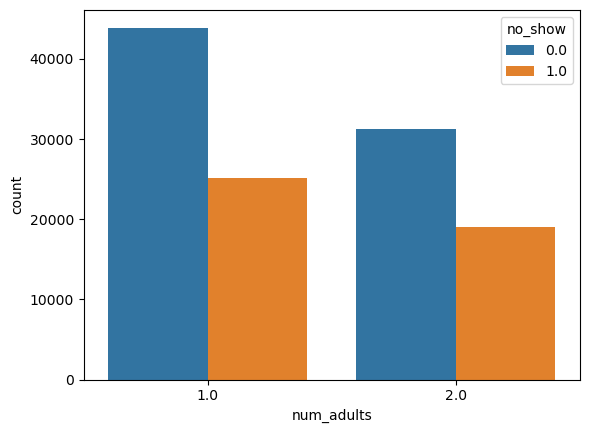

In [24]:
sns.countplot(data = df, x = 'num_adults', hue = 'no_show')
plt.show()

## `num_children` and `no_show`

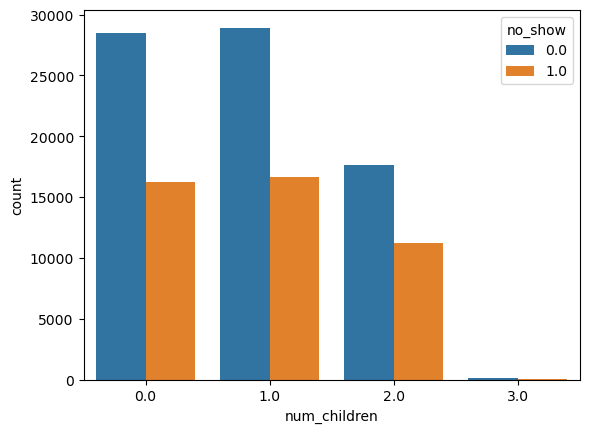

In [25]:
sns.countplot(data = df, x = 'num_children', hue = 'no_show')
plt.show()

## `length_of_stay` and `no_show`

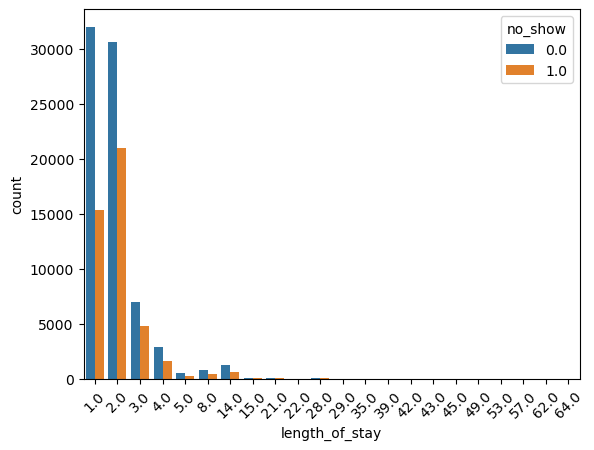

In [26]:
length_plot = sns.countplot(data = df, x = 'length_of_stay', hue = 'no_show')
length_plot.set_xticklabels(length_plot.get_xticklabels(), rotation=45)
plt.show()

# try proportions/percentage instead of raw values

Now that we observe the relationships between the different variables and `no_show`, we will choose the variables that are observed to have an effect on it.

In [27]:
X = df[['branch', 'country', 'first_time', 'price', 'room', 'platform', 'num_adults', 'num_children', 'length_of_stay']]

Now, we can look to split our data. We will create 3 data sets, 1 for training, 1 for validation, 1 for testing. We will split them as such: 65% for training, 15% for validation, 20% for testing.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 3/16, stratify = y_train)

First things first, let's impute the missing data that we previously discovered. These missing data appeared in the `room` and `price` variables.

In [29]:
price_imp = SimpleImputer(strategy = 'mean')
X_train['price'] = price_imp.fit_transform(np.array(X_train['price']).reshape(-1, 1)).ravel()
X_val['price'] = price_imp.transform(np.array(X_val['price']).reshape(-1, 1)).ravel()
X_test['price'] = price_imp.transform(np.array(X_test['price']).reshape(-1, 1)).ravel()

room_imp = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
X_train['room'] = room_imp.fit_transform(np.array(X_train['room']).reshape(-1, 1)).ravel()
X_val['room'] = room_imp.transform(np.array(X_val['room']).reshape(-1, 1)).ravel()
X_test['room'] = room_imp.transform(np.array(X_test['room']).reshape(-1, 1)).ravel()

After imputing our data, now we will perform scaling of our numerical variables, and one hot encoding of our categorical variables

In [30]:
print(X_train.describe())

numeric_columns = ['price', 'num_adults', 'num_children', 'length_of_stay']
categorical_columns = ['branch', 'country', 'first_time', 'room', 'platform']

pipeline = ColumnTransformer([
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(), categorical_columns),
])

              price    num_adults  num_children  length_of_stay
count  77603.000000  77603.000000  77603.000000    77603.000000
mean     941.552166      1.421466      0.870211        2.105782
std      235.842410      0.493797      0.780840        2.169788
min      394.213500      1.000000      0.000000        1.000000
25%      840.793500      1.000000      0.000000        1.000000
50%      941.552166      1.000000      1.000000        2.000000
75%      968.909250      2.000000      1.000000        2.000000
max     2098.830000      2.000000      3.000000       64.000000


In [31]:
X_train = pipeline.fit_transform(X_train)
X_val = pipeline.transform(X_val)
X_test = pipeline.transform(X_test)

In [32]:
print(X_train.shape)
print(type(X_train))
print(pd.DataFrame(X_train).head())

(77603, 23)
<class 'numpy.ndarray'>
             0         1         2         3    4    5    6    7    8    9   \
0 -9.337658e-01 -0.853526 -1.114463 -0.048753  0.0  1.0  0.0  1.0  0.0  0.0   
1 -4.820489e-16 -0.853526 -1.114463 -0.048753  0.0  1.0  0.0  1.0  0.0  0.0   
2 -4.820489e-16 -0.853526  0.166218 -0.509630  1.0  0.0  0.0  1.0  0.0  0.0   
3 -4.820489e-16 -0.853526 -1.114463 -0.048753  1.0  0.0  0.0  0.0  0.0  1.0   
4  7.016524e-02  1.171611  0.166218  5.481778  0.0  1.0  1.0  0.0  0.0  0.0   

   ...   13   14   15   16   17   18   19   20   21   22  
0  ...  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  
1  ...  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  
2  ...  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  
3  ...  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  
4  ...  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  

[5 rows x 23 columns]


# Modelling
We will proceed to perform modelling on our data. The models that we are using will be:
1. Logistic Regression
2. Random Forest Classifier
3. Neural Network

## Logistic Regression

In [33]:
log_model = LogisticRegression(solver = "newton-cholesky", warm_start = True)
log_model.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
log_pred = log_model.predict(X_test)

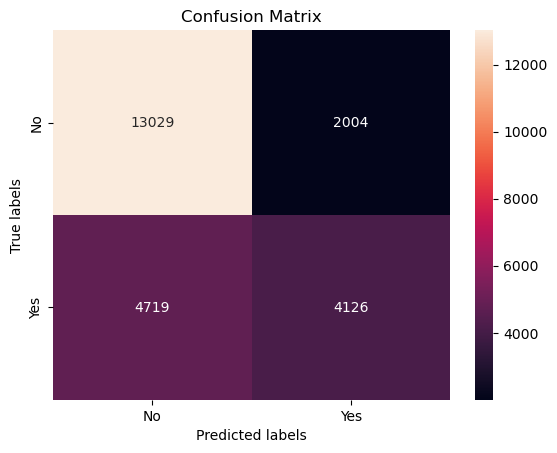

0.7184437557584388
              precision    recall  f1-score   support

         0.0       0.73      0.87      0.79     15033
         1.0       0.67      0.47      0.55      8845

    accuracy                           0.72     23878
   macro avg       0.70      0.67      0.67     23878
weighted avg       0.71      0.72      0.70     23878



In [34]:
log_cm = confusion_matrix(y_test, log_pred)

labels = ['No','Yes']
ax = plt.subplot()
sns.heatmap(log_cm, annot=True, ax = ax, fmt="d"); # annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

print(accuracy_score(y_test, log_pred))
print(classification_report(y_test, log_pred))

### Logistic Regression Re-tuning

In [35]:
log_model = LogisticRegression(penalty = 'l2', warm_start = True)

log_params = {
    'tol': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    'C': [2, 1, 0.5],
    'max_iter': [100, 200, 300, 400],
    'solver': ['liblinear', 'newton-cholesky', 'lbfgs', 'saga', 'sag', 'newton-cg']
}

log_clf = RandomizedSearchCV(estimator = log_model, 
                             param_distributions = log_params, 
                             scoring = 'accuracy',
                             refit = True,
                             cv = 5,
                             verbose = 2,
                             n_iter = 25,
                             n_jobs = -1)

log_search = log_clf.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [36]:
print(log_search.best_params_)

log_best = log_search.best_estimator_
log_best_pred = log_best.predict(X_test)

{'tol': 0.001, 'solver': 'sag', 'max_iter': 200, 'C': 2}


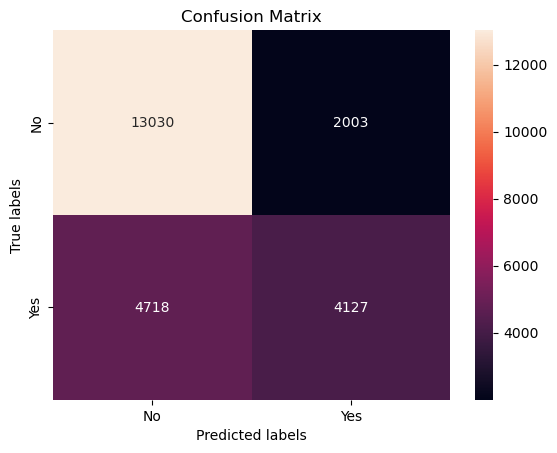

0.7185275148672419
              precision    recall  f1-score   support

         0.0       0.73      0.87      0.79     15033
         1.0       0.67      0.47      0.55      8845

    accuracy                           0.72     23878
   macro avg       0.70      0.67      0.67     23878
weighted avg       0.71      0.72      0.70     23878



In [37]:
log_best_cm = confusion_matrix(y_test, log_best_pred)

labels = ['No','Yes']
ax = plt.subplot()
sns.heatmap(log_best_cm, annot=True, ax = ax, fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

print(accuracy_score(y_test, log_best_pred))
print(classification_report(y_test, log_best_pred))

## Random Forest Classifier

In [38]:
rfc_model = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', max_depth = 3, min_samples_split = 3)
rfc_model.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
rfc_pred = rfc_model.predict(X_test)

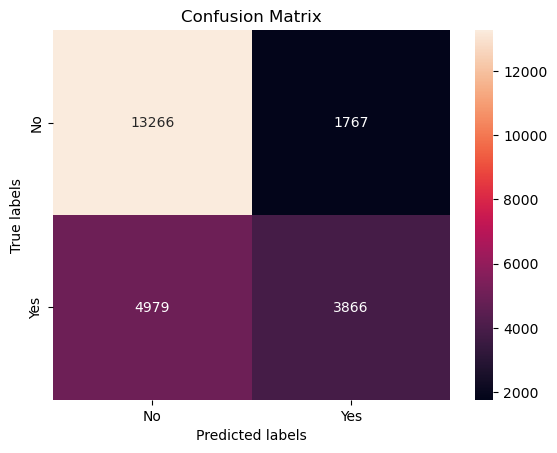

0.7174805260072032
              precision    recall  f1-score   support

         0.0       0.73      0.88      0.80     15033
         1.0       0.69      0.44      0.53      8845

    accuracy                           0.72     23878
   macro avg       0.71      0.66      0.67     23878
weighted avg       0.71      0.72      0.70     23878



In [39]:
rfc_cm = confusion_matrix(y_test, rfc_pred)

labels = ['No','Yes']
ax = plt.subplot()
sns.heatmap(rfc_cm, annot=True, ax = ax, fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

print(accuracy_score(y_test, rfc_pred))
print(classification_report(y_test, rfc_pred))

### Random Forest Classifier Re-tuning

In [40]:
rfc_model = RandomForestClassifier()


rfc_params = {
    'max_depth': [int(x) for x in np.linspace(10, 30, 3)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [int(x) for x in np.linspace(100, 300, 5)],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'bootstrap': [True, False]
}

rfc_clf = RandomizedSearchCV(estimator = rfc_model, 
                             param_distributions = rfc_params, 
                             scoring = 'accuracy',
                             refit = True,
                             verbose = 2,
                             n_iter = 25,
                             n_jobs = -1)

rfc_search = rfc_clf.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [41]:
print(rfc_search.best_params_)

rfc_best = rfc_search.best_estimator_
rfc_best_pred = rfc_best.predict(X_test)

{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10, 'criterion': 'log_loss', 'bootstrap': False}


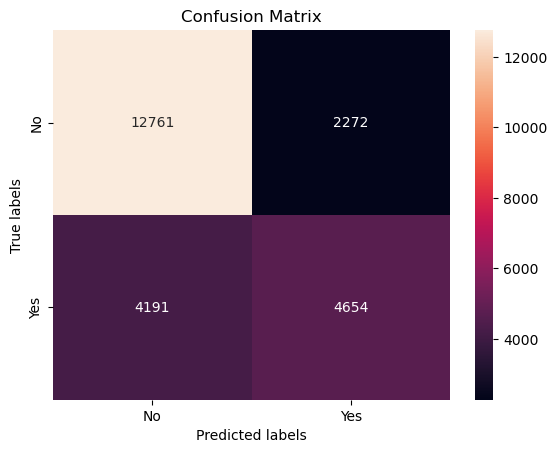

0.7293324399028395
              precision    recall  f1-score   support

         0.0       0.75      0.85      0.80     15033
         1.0       0.67      0.53      0.59      8845

    accuracy                           0.73     23878
   macro avg       0.71      0.69      0.69     23878
weighted avg       0.72      0.73      0.72     23878



In [42]:
rfc_best_cm = confusion_matrix(y_test, rfc_best_pred)

labels = ['No','Yes']
ax = plt.subplot()
sns.heatmap(rfc_best_cm, annot=True, ax = ax, fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

print(accuracy_score(y_test, rfc_best_pred))
print(classification_report(y_test, rfc_best_pred))

## Neural Network

In [43]:
n_features = X_train.shape[1] # 23
n_obs = X_train.shape[0] # 77603

nnm = Sequential(
    [
        layers.Dense(n_features, activation = layers.LeakyReLU(0.1)),
        layers.Dense(64, activation = layers.LeakyReLU(0.1)),
        layers.Dropout(0.25),
        layers.Dense(32, activation = layers.LeakyReLU(0.1)),
        layers.Dropout(0.25),
        layers.Dense(16, activation = layers.LeakyReLU(0.1)),
        layers.Dropout(0.25),
        layers.Dense(4, activation = layers.LeakyReLU(0.1)),
        layers.Dense(1, activation = 'sigmoid')
    ]
)

nnm.compile(optimizer = optimizers.Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])
nnm.fit(X_train, y_train, epochs = 5, verbose = 1, validation_data = (X_val, y_val))

Epoch 1/5
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.6870 - loss: 0.6030 - val_accuracy: 0.7218 - val_loss: 0.5688
Epoch 2/5
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7242 - loss: 0.5694 - val_accuracy: 0.7248 - val_loss: 0.5688
Epoch 3/5
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7247 - loss: 0.5654 - val_accuracy: 0.7210 - val_loss: 0.5661
Epoch 4/5
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7249 - loss: 0.5664 - val_accuracy: 0.7238 - val_loss: 0.5656
Epoch 5/5
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7266 - loss: 0.5649 - val_accuracy: 0.7247 - val_loss: 0.5661


In [44]:
nnm_pred = nnm.predict(X_test)
threshold = 0.5
nnm_pred = [1 if pred > threshold else 0 for pred in nnm_pred]
print(np.array(nnm_pred).sum())

747/747 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step
7372


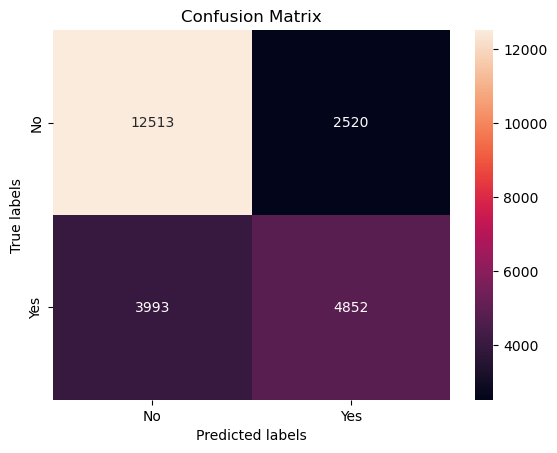

0.7272384621827623
              precision    recall  f1-score   support

         0.0       0.76      0.83      0.79     15033
         1.0       0.66      0.55      0.60      8845

    accuracy                           0.73     23878
   macro avg       0.71      0.69      0.70     23878
weighted avg       0.72      0.73      0.72     23878



In [45]:
nnm_cm = confusion_matrix(y_test, nnm_pred)

labels = ['No','Yes']
ax = plt.subplot()
sns.heatmap(nnm_cm, annot=True, ax = ax, fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

print(accuracy_score(y_test, nnm_pred))
print(classification_report(y_test, nnm_pred))

### Neural Network Re-tuning

In [48]:
def create_model(dropout_rate, lr, relu_slope, layer1, layer2, layer3, layer4):
    model = Sequential([
        layers.Dense(layer1, activation=layers.LeakyReLU(relu_slope), input_shape = (n_features,)),
        layers.Dropout(dropout_rate),
        layers.Dense(layer2, activation=layers.LeakyReLU(relu_slope)),
        layers.Dropout(dropout_rate),
        layers.Dense(layer3, activation=layers.LeakyReLU(relu_slope)),
        layers.Dropout(dropout_rate),
        layers.Dense(layer4, activation=layers.LeakyReLU(relu_slope)),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer = optimizers.Adam(learning_rate=lr), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [49]:
nnm_params = {
    'dropout_rate': [0.2, 0.25],
    'lr': [0.01, 0.001, 0.0001],
    'batch_size': [4096, 8192, 16384],
    'epochs': [int(i) for i in np.linspace(20, 100, 5)],
    'layer1': [32, 64],
    'layer2': [16, 32],
    'layer3': [8, 16],
    'layer4': [4, 8],
    'relu_slope': [0.1, 0.2, 0.3]
}

nnm_model = KerasClassifier(model = create_model, lr = 0.001, dropout_rate = 0.25, 
                            layer1 = 32, layer2 = 16, layer3 = 8, layer4 = 4, relu_slope = 0.1)

nnm_clf = RandomizedSearchCV(estimator = nnm_model, 
                             param_distributions = nnm_params, 
                             refit = True,
                             verbose = 2,
                             n_iter = 25,
                             n_jobs = -1)

nnm_search = nnm_clf.fit(X = X_train, y = y_train, validation_data = (X_val, y_val))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


C:\Users\Owent\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
C:\Users\Owent\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.5768 - loss: 0.6755 - val_accuracy: 0.6296 - val_loss: 0.6319
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6287 - loss: 0.6355 - val_accuracy: 0.6296 - val_loss: 0.6123
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6283 - loss: 0.6168 - val_accuracy: 0.6349 - val_loss: 0.5991
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6654 - loss: 0.6025 - val_accuracy: 0.7153 - val_loss: 0.5910
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7105 - loss: 0.5930 - val_accuracy: 0.7157 - val_loss: 0.5833
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7144 - loss: 0.5863 - val_accuracy: 0.7198 - val_loss: 0.5757
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7181 - loss: 0.5778 - val_accuracy: 0.7149 - val_loss: 0.5764
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7169 - loss: 0.5777 - val_accuracy: 0.7143 - val_loss:

Epoch 52/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7265 - loss: 0.5616 - val_accuracy: 0.7249 - val_loss: 0.5657
Epoch 53/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7278 - loss: 0.5619 - val_accuracy: 0.7247 - val_loss: 0.5658
Epoch 54/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7281 - loss: 0.5617 - val_accuracy: 0.7247 - val_loss: 0.5658
Epoch 55/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7269 - loss: 0.5613 - val_accuracy: 0.7249 - val_loss: 0.5651
Epoch 56/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7274 - loss: 0.5609 - val_accuracy: 0.7252 - val_loss: 0.5648
Epoch 57/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7272 - loss: 0.5626 - val_accuracy: 0.7249 - val_loss: 0.5658
Epoch 58/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7282 - loss: 0.5605 - val_accuracy: 0.7240 - val_loss: 0.5653
Epoch 59/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7280 - loss: 0.5607 - val_accuracy: 0.7237 - v

In [50]:
print(nnm_search.best_params_)

nnm_best = nnm_search.best_estimator_

nnm_best_pred = nnm_best.predict(X_test)
threshold = 0.5
nnm_best_pred = [1 if pred > threshold else 0 for pred in nnm_best_pred]
print(np.array(nnm_best_pred).sum())

{'relu_slope': 0.1, 'lr': 0.01, 'layer4': 4, 'layer3': 16, 'layer2': 16, 'layer1': 64, 'epochs': 100, 'dropout_rate': 0.25, 'batch_size': 16384}
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
7101


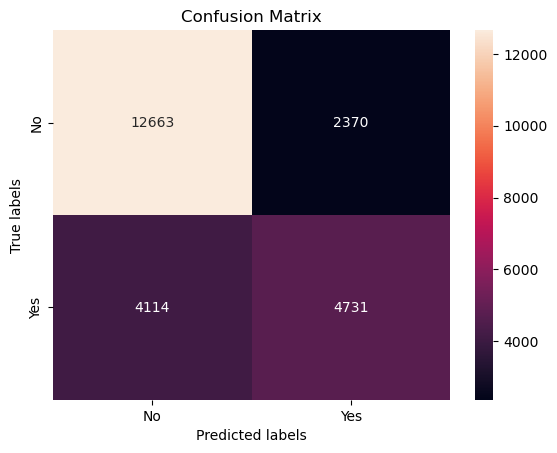

0.728452969260407
              precision    recall  f1-score   support

         0.0       0.75      0.84      0.80     15033
         1.0       0.67      0.53      0.59      8845

    accuracy                           0.73     23878
   macro avg       0.71      0.69      0.69     23878
weighted avg       0.72      0.73      0.72     23878



In [51]:
nnm_best_cm = confusion_matrix(y_test, nnm_best_pred)

labels = ['No','Yes']
ax = plt.subplot()
sns.heatmap(nnm_best_cm, annot=True, ax = ax, fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

print(accuracy_score(y_test, nnm_best_pred))
print(classification_report(y_test, nnm_best_pred))

# Model Evaluation
To evaluate the models, we will look at their accuracies as follows:
1. Logistic Regression - 71.84% / 71.85%
2. Random Forest Classifier - 71.75% / 72.93%
3. Neural Network - 72.72% / 72.85%